# 图像拼接

In [1]:
# 导入相应库
import cv2
import numpy as np
import matplotlib.pyplot as plt
# 方便使用plot( )以及在figure画布上直接绘图
%matplotlib inline

(<matplotlib.axes._subplots.AxesSubplot at 0x124028a50>,
 Text(0.5, 1.0, 'patch'))

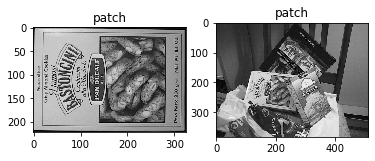

In [11]:
# 读取输入图像
img_patch = cv2.imread('./images_for_note/feature/box.png')
img_global = cv2.imread('./images_for_note/feature/box_in_scene.png')
plt.subplot(121), plt.imshow(img_patch), plt.title('patch')
plt.subplot(122), plt.imshow(img_global), plt.title('patch')

In [12]:
# 提取特征点，这里选用SIFT
sift = cv2.xfeatures2d.SIFT_create()

kp1, des1 = sift.detectAndCompute(img_patch, None)
kp2, des2 = sift.detectAndCompute(img_global, None)

# crossCheck表示两个特征点要互相匹配（双向性）
# NORM_L2: 归一化数组的欧氏距离，如果采用其他的特征计算方法则需要考虑使用不同的匹配计算方式
bf = cv2.BFMatcher(crossCheck=True)

### 1对1的特征点匹配（蛮力匹配）

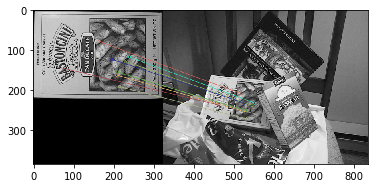

In [17]:
matches = bf.match(des1, des2)
matches = sorted(matches, key= lambda x: x.distance)

img_match = cv2.drawMatches(img_patch, kp1, img_global, kp2, matches[:10], None, flags=2)
plt.imshow(img_match)

### k对特征点匹配

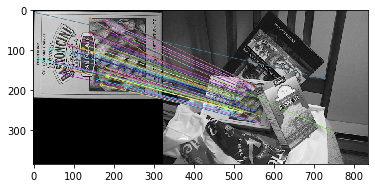

In [19]:
bf_k = cv2.BFMatcher()
matches_k = bf_k.knnMatch(des1, des2, k=2)

good = []
for m, n in matches_k:
    if m.distance < 0.75*n.distance:
        good.append([m])
        
img_match_k = cv2.drawMatchesKnn(img_patch, kp1, img_global, kp2, good, None, flags=2)
plt.imshow(img_match_k)

> 如果需要更快速完成操作，可以尝试使用`cv2.FlannBasedMatcher`
### 随机抽样一致算法（Random sample consensus——RANSAC）
可以避免异常点对于整体拟合效果的影响
1. 选择初始样本点进行拟合，给定一个容忍范围，不断进行迭代
2. 每一次拟合后，容差范围内都有对应的数据点数，找出数据点个数最多的情况，就是最终的拟合效果

### 单应性矩阵
$$
H = \begin{pmatrix}h_{11}&h_{12}&h_{13}\\h_{21}&h_{22}&h_{23}\\ h_{31}&h_{32}&1 \end{pmatrix}
$$
$$
\begin{pmatrix}x'\\y'\\1 \end{pmatrix}=\begin{pmatrix}h_{11}&h_{12}&h_{13}\\h_{21}&h_{22}&h_{23}\\ h_{31}&h_{32}&1 \end{pmatrix}\begin{pmatrix}x\\y\\1 \end{pmatrix}
$$

矩阵中有8个待求参数，至少需要四个匹配点坐标来求。在求取过程中会使用RANSAC算法。